In [1]:
#import tensorflow as tf
#tf.reset_default_graph()
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
TRAIN_CSV_FILE = "train.csv"
TEST_CSV_FILE = "test.csv"
RODOLFO_CSV_FILE = "rodolfo.csv"
ANKUR_CSV_FILE = "ankur.csv"
CAROLINE_CSV_FILE = "caroline.csv"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    genres = '1 2 3 4 5 6 7 8 9 0'.split()
    for filename in os.listdir(soundFilesFolder):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

# comment these lines if you already have train.csv and test.csv files
#extractWavFeatures("../data/recordings/train", TRAIN_CSV_FILE)
#extractWavFeatures("../data/recordings/test", TEST_CSV_FILE)
#extractWavFeatures("../data/recordings/rodolfo", RODOLFO_CSV_FILE)
#extractWavFeatures("../data/recordings/ankur", ANKUR_CSV_FILE)
#extractWavFeatures("../data/recordings/caroline", CAROLINE_CSV_FILE)



In [4]:
#Reading a dataset and convert file name to corresbonding umnber

import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    # we have three speakers: 
    # 0: Jackson
    # 1: Nicolas 
    # 2: Theo
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = filenameArray[i][2]
        #print(speaker)
        if speaker == "j":
            speaker = "0"
        elif speaker == "n":
            speaker = "1"
        elif speaker == "t":
            speaker = "2"
        elif speaker == "a":
            speaker = "3"
        elif speaker == "c":
            speaker = "4"
        elif speaker == "r":
            speaker = "5"
        else: 
            speaker = "6"
        #print(speaker)
        speakerArray.append(speaker)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data

trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)
rodolfoData = preProcessData(RODOLFO_CSV_FILE)
ankurData = preProcessData(ANKUR_CSV_FILE)
carolineData = preProcessData(CAROLINE_CSV_FILE)


train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.039759        1358.208628         1890.243941  2540.917969   
1  0.302424         879.994019         1137.986581  1826.501859   
2  0.112672         741.829081          758.492178  1438.494873   
3  0.090344         635.610880          670.336296  1160.452403   
4  0.091456         667.786694          732.606545  1257.180176   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.093363 -349.631744  135.204880  19.397516  12.044560   
1            0.031423 -225.136642  150.581146 -11.930015   5.277394   
2            0.034023 -295.578461  189.853683 -19.606564   6.078507   
3            0.033458 -339.148743  204.005249  -7.485526  14.297898   
4            0.033268 -327.507416  195.596924  -3.994768  21.315840   

       mfcc5  ...     mfcc12     mfcc13     mfcc14     mfcc15     mfcc16  \
0  -8.521679  ... -12.872719  -3.1183

In [5]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

X_rodolfo = np.array(rodolfoData.iloc[:, :-1], dtype = float)
y_rodolfo = rodolfoData.iloc[:, -1]

X_ankur = np.array(ankurData.iloc[:, :-1], dtype = float)
y_ankur = ankurData.iloc[:, -1]

X_caroline = np.array(carolineData.iloc[:, :-1], dtype = float)
y_caroline = carolineData.iloc[:, -1]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(y_rodolfo.shape)
print(y_ankur.shape)
print(y_caroline.shape)

(1050,)
(450,)
(30,)
(10,)
(10,)
(10,)


In [6]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )
X_rodolfo = scaler.transform( X_rodolfo )
X_ankur = scaler.transform( X_ankur )
X_caroline = scaler.transform( X_caroline )

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_rodolfo.shape)
print(X_ankur.shape)
print(X_caroline.shape)


(1050, 25)
(450, 25)
(30, 25)
(10, 25)
(10, 25)
(10, 25)


In [7]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))



Using TensorFlow backend.


In [8]:
# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [10]:
#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])



Train on 1050 samples, validate on 450 samples
Epoch 1/50
1050/1050 [==============================] - 0s 334us/step - loss: 2.2817 - accuracy: 0.1857 - val_loss: 1.7404 - val_accuracy: 0.6044
Epoch 2/50
1050/1050 [==============================] - 0s 37us/step - loss: 1.5879 - accuracy: 0.4848 - val_loss: 1.1591 - val_accuracy: 0.7800
Epoch 3/50
1050/1050 [==============================] - 0s 38us/step - loss: 1.1431 - accuracy: 0.6219 - val_loss: 0.6928 - val_accuracy: 0.9133
Epoch 4/50
1050/1050 [==============================] - 0s 42us/step - loss: 0.8276 - accuracy: 0.7333 - val_loss: 0.4181 - val_accuracy: 0.9156
Epoch 5/50
1050/1050 [==============================] - 0s 50us/step - loss: 0.6313 - accuracy: 0.8143 - val_loss: 0.2790 - val_accuracy: 0.9311
Epoch 6/50
1050/1050 [==============================] - 0s 50us/step - loss: 0.4443 - accuracy: 0.8829 - val_loss: 0.2062 - val_accuracy: 0.9600
Epoch 7/50
1050/1050 [==============================] - 0s 61us/step - loss: 0.329

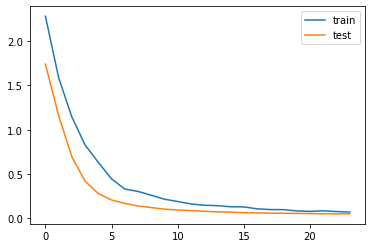

In [11]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [12]:
def getSpeaker(speaker):
    speaker = str(speaker)
    if speaker == "0":
        return "Jackson"
    elif speaker == "1":
        return "Nicola"
    elif speaker == "2":
        return "Theo"
    elif speaker == "3":
        return "Ankur"
    elif speaker == "4":
        return "Caroline"
    elif speaker == "5":
        return "Rodolfo"
    else: 
        speaker = "Unknown"
        
def printPrediction(X_data, y_data, printDigit):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        prediction = getSpeaker(model.predict_classes(X_data[i:i+1])[0])
        speaker = getSpeaker(y_data[i])
        if printDigit == True:
            print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
            print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [13]:
print('\n# TEST DATA #\n')
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_test, y_test, False)


# TEST DATA #

30/30 [==============================] - 0s 33us/step
accuracy: 100.00%

# Generate predictions
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction=Jackson   - match=True
y=Nicola    - prediction=Nicola    - match=True
y=Theo      - prediction=Theo      - match=True
y=Jackson   - prediction

In [14]:
print('\n# RODOLFO DATA #\n')
score = model.evaluate(X_rodolfo, y_rodolfo)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_rodolfo, y_rodolfo, True)



# RODOLFO DATA #

10/10 [==============================] - 0s 405us/step
accuracy: 10.00%

# Generate predictions
Number=0, y=Rodolfo   - prediction=Jackson   - match=False
Number=1, y=Rodolfo   - prediction=Ankur     - match=False
Number=2, y=Rodolfo   - prediction=Ankur     - match=False
Number=3, y=Rodolfo   - prediction=Rodolfo   - match=True
Number=4, y=Rodolfo   - prediction=Jackson   - match=False
Number=5, y=Rodolfo   - prediction=Caroline  - match=False
Number=6, y=Rodolfo   - prediction=Jackson   - match=False
Number=7, y=Rodolfo   - prediction=Caroline  - match=False
Number=8, y=Rodolfo   - prediction=Jackson   - match=False
Number=9, y=Rodolfo   - prediction=Caroline  - match=False


In [15]:
print('\n# ANKUR DATA #\n')
score = model.evaluate(X_ankur, y_ankur)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Predection
printPrediction(X_ankur, y_ankur, True)


# ANKUR DATA #

10/10 [==============================] - 0s 100us/step
accuracy: 100.00%

# Generate predictions
Number=0, y=Ankur     - prediction=Ankur     - match=True
Number=1, y=Ankur     - prediction=Ankur     - match=True
Number=2, y=Ankur     - prediction=Ankur     - match=True
Number=3, y=Ankur     - prediction=Ankur     - match=True
Number=4, y=Ankur     - prediction=Ankur     - match=True
Number=5, y=Ankur     - prediction=Ankur     - match=True
Number=6, y=Ankur     - prediction=Ankur     - match=True
Number=7, y=Ankur     - prediction=Ankur     - match=True
Number=8, y=Ankur     - prediction=Ankur     - match=True
Number=9, y=Ankur     - prediction=Ankur     - match=True


In [16]:
print('\n# CAROLINE DATA #\n')
score = model.evaluate(X_caroline, y_caroline)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Predection
printPrediction(X_caroline, y_caroline, True)


# CAROLINE DATA #

10/10 [==============================] - 0s 100us/step
accuracy: 50.00%

# Generate predictions
Number=0, y=Caroline  - prediction=Caroline  - match=True
Number=1, y=Caroline  - prediction=Caroline  - match=True
Number=2, y=Caroline  - prediction=Caroline  - match=True
Number=3, y=Caroline  - prediction=Caroline  - match=True
Number=4, y=Caroline  - prediction=Jackson   - match=False
Number=5, y=Caroline  - prediction=Ankur     - match=False
Number=6, y=Caroline  - prediction=Ankur     - match=False
Number=7, y=Caroline  - prediction=Ankur     - match=False
Number=8, y=Caroline  - prediction=Ankur     - match=False
Number=9, y=Caroline  - prediction=Caroline  - match=True


In [17]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = model.predict_classes(X_data)
    y_data_num = y_data.astype(np.int64)
    print('Confusion Matrix')
    print(confusion_matrix(y_data_num, Y_pred))
    print('\nClassification Report')
    target_names = ["Jackson", "Nicola", "Theo", "Ankur", "Caroline", "Rodolfo", "Unknown"]
    print(classification_report(y_data_num, Y_pred))


In [18]:
print("Classification Report for Train Data\n")
report(X_train, y_train)

print("Classification Report for Validation Data\n")
report(X_val, y_val)

print("Classification Report for Test Data\n")
report(X_test, y_test)

print("Classification Report for Ankur\n")
report(X_ankur, y_ankur)

print("Classification Report for Caroline\n")
report(X_caroline, y_caroline)

print("Classification Report for Rodolfo\n")
report(X_rodolfo, y_rodolfo)

Classification Report for Train Data

Confusion Matrix
[[347   0   0   0   0   0]
 [  0 343   0   0   0   0]
 [  1   0 337   0   0   0]
 [  0   0   0   9   0   0]
 [  1   0   0   4   2   0]
 [  0   0   0   6   0   0]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       347
           1       1.00      1.00      1.00       343
           2       1.00      1.00      1.00       338
           3       0.47      1.00      0.64         9
           4       1.00      0.29      0.44         7
           5       0.00      0.00      0.00         6

    accuracy                           0.99      1050
   macro avg       0.74      0.71      0.68      1050
weighted avg       0.99      0.99      0.99      1050

Classification Report for Validation Data

Confusion Matrix
[[142   1   0   0   0   0]
 [  0 147   0   0   0   0]
 [  2   0 150   0   0   0]
 [  0   0   0   1   0   0]
 [  0   0   0   2   1   0]
 [  0   0   0   4   0

c:\users\erodvas\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\erodvas\env\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
